In [1]:
import numpy as np
from PIL import Image
import glob
import matplotlib.pyplot as plt

In [3]:
def flood_fill(image, x, y, visited):
    stack = [(x, y)]  # Initialize stack with the starting pixel

    while stack:
        x, y = stack.pop()

        if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
            continue  # Skip out-of-bounds pixels
        if image[y, x] == 1 or visited[y, x]:
            continue  # Skip edge pixels and already visited pixels

        visited[y, x] = True  # Mark the pixel as visited

        # Add the neighboring pixels to the stack
        stack.append((x + 1, y))  # Right
        stack.append((x - 1, y))  # Left
        stack.append((x, y + 1))  # Down
        stack.append((x, y - 1))  # Up


def outer_edge_detector(image):
    visited = np.zeros_like(image)  # Initialize the visited array

    # Apply flood fill to the boundary pixels of the image
    for i in range(image.shape[0]):
        flood_fill(image, 0, i, visited)
        flood_fill(image, image.shape[1] - 1, i, visited)

    for j in range(image.shape[1]):
        flood_fill(image, j, 0, visited)
        flood_fill(image, j, image.shape[0] - 1, visited)

    return visited

In [4]:
from scipy.ndimage import convolve, binary_erosion
import os

subfolder = "train"

image_files = glob.glob(f"./data/lego/{subfolder}/*.png")
os.makedirs(f"./data/lego/{subfolder}_processed", exist_ok=True)

sharpening_kernel = np.array([[0, -1, 0],
                              [-1,  5, -1],
                              [0, -1, 0]])

sharpening_kernel_2 = np.array([[-1, -1, -1],
                              [-1,  8, -1],
                              [-1, -1, -1]])

def find_thick_edges(image):
    image = image > 128
    # Define the structuring element size for erosion
    structuring_element_size = 2  # Adjust this to target different edge thicknesses
    structuring_element = np.ones((structuring_element_size, structuring_element_size))

    # Apply erosion
    eroded_edges = binary_erosion(image, structure=structuring_element)

    # Find edges that are thick enough (present in both original and eroded maps)
    thick_edges = np.logical_and(image, eroded_edges)

    # Convert back to an image
    return np.clip(thick_edges.astype(np.uint8) * 255, 0, 255)

for image in image_files:
    i = np.array(Image.open(image).convert("L"))

    i_rgb = np.array(Image.open(image).convert("RGB"))

    i_filtered = i > 125

    mask = outer_edge_detector(i_filtered)
    saved = Image.fromarray(mask)
    saved.save(image.replace(subfolder, f"{subfolder}_processed"))

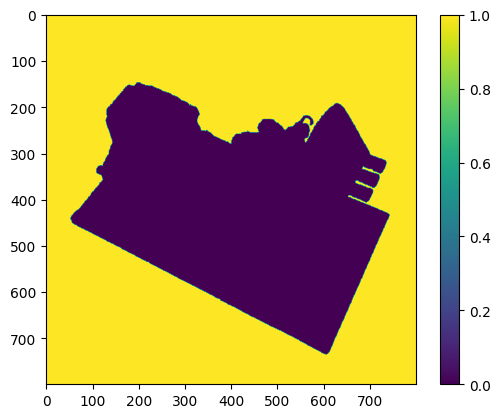

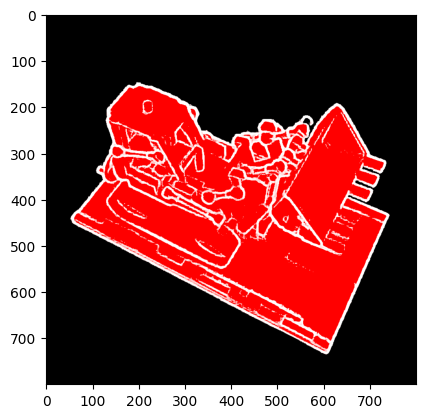

In [87]:
manual_process = ["./data/lego/train/r_93.png"]

for m_p in manual_process:
    i = np.array(Image.open(m_p).convert("L"))

    i_rgb = np.array(Image.open(m_p).convert("RGB"))

    i_filtered = i > 180

    mask = outer_edge_detector(i_filtered)
    plt.figure()
    plt.imshow(mask)
    plt.colorbar()
    i_rgb_r = i_rgb[..., 0]
    i_rgb_r[i_rgb_r < 150] = 0
    i_rgb_g = i_rgb[..., 1]
    i_rgb_g[i_rgb_g < 150] = 0
    i_rgb_b = i_rgb[..., 2]
    i_rgb_b[i_rgb_b < 150] = 0
    i_rgb_r[(~mask) & ((i > 255) == 0)] = 255

    saved = Image.fromarray(np.stack([i_rgb_r, i_rgb_g, i_rgb_b], axis=-1))
    plt.figure()
    plt.imshow(saved)
    #saved.save(m_p.replace("train", "train_processed"))

In [9]:
processed_files = glob.glob("./data/lego/train_processed/*.png")

def threshold(pixel, threshold):
    r, g, b = pixel
    return r > 20 and g > 20 and b > 20 

def remove_connected_red_pixels(img_array, start_x, start_y, red_threshold):
    stack = [(start_x, start_y)]

    while stack:
        x, y = stack.pop()

        if x < 0 or x >= img_array.shape[1] or y < 0 or y >= img_array.shape[0]:
            continue
        if not threshold(img_array[y, x], red_threshold):
            continue

        img_array[y, x] = 0

        # Add neighboring pixels to the stack
        stack.extend([(x-1, y), (x+1, y), (x, y-1), (x, y+1)])

def remove_red_boundary_pixels(image_path, threshold_val=150, width=3):
    img = Image.open(image_path).convert("RGB")
    img_array = np.array(img)
    # Process the boundary pixels
    for w in range(width):
        for y in range(img_array.shape[0]):
            if threshold(img_array[y, w], threshold_val):
                remove_connected_red_pixels(img_array, w, y, threshold_val)
            if threshold(img_array[y, -1-w], threshold_val):
                remove_connected_red_pixels(img_array, img_array.shape[1] - 1 - w, y, threshold_val)

        for x in range(img_array.shape[1]):
            if threshold(img_array[w, x], threshold_val):
                remove_connected_red_pixels(img_array, x, w, threshold_val)
            if threshold(img_array[-1-w, x], threshold_val):
                remove_connected_red_pixels(img_array, x, img_array.shape[0] - 1 - w, threshold_val)

    result_img = Image.fromarray(img_array)
    result_img.save(image_path)

for processed_file in processed_files:
    print(processed_file)
    remove_red_boundary_pixels(processed_file)

./data/lego/train_processed\r_0.png
./data/lego/train_processed\r_1.png
./data/lego/train_processed\r_10.png
./data/lego/train_processed\r_11.png
./data/lego/train_processed\r_12.png
./data/lego/train_processed\r_13.png
./data/lego/train_processed\r_14.png
./data/lego/train_processed\r_15.png
./data/lego/train_processed\r_16.png
./data/lego/train_processed\r_17.png
./data/lego/train_processed\r_18.png
./data/lego/train_processed\r_19.png
./data/lego/train_processed\r_2.png
./data/lego/train_processed\r_20.png
./data/lego/train_processed\r_21.png
./data/lego/train_processed\r_22.png
./data/lego/train_processed\r_23.png
./data/lego/train_processed\r_24.png
./data/lego/train_processed\r_25.png
./data/lego/train_processed\r_26.png
./data/lego/train_processed\r_27.png
./data/lego/train_processed\r_28.png
./data/lego/train_processed\r_29.png
./data/lego/train_processed\r_3.png
./data/lego/train_processed\r_30.png
./data/lego/train_processed\r_31.png
./data/lego/train_processed\r_32.png
./dat